In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [68]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['photoC_TOT_zint','zoo1C','zoo2C','zoo3C','zoo4C',
             'diatC','spC','coccoC','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_diat_zint','photoC_sp_zint','photoC_cocco_zint','SHF_QSW',
            'diat_light_lim_Cweight_avg_100m','sp_light_lim_Cweight_avg_100m']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [69]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
photoC_TOT_zint
zoo1C
zoo2C
zoo3C
zoo4C
diatC
spC
coccoC
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
SHF_QSW
diat_light_lim_Cweight_avg_100m
sp_light_lim_Cweight_avg_100m
CPU times: user 10.2 s, sys: 3.05 s, total: 13.3 s
Wall time: 16.1 s


In [70]:
ds

<xarray.Dataset>
Dimensions:                          (nlat: 384, nlon: 320, time: 61, z_t: 60, z_t_150m: 15)
Coordinates:
  * time                             (time) object 0001-12-31 00:00:00 ... 00...
    TLONG                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                              (z_t) float32 500.0 1.5e+03 ... 5.375e+05
Dimensions without coordinates: nlat, nlon, z_t_150m
Data variables:
    TAREA                            (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    KMT                              (time, nlat, nlon) float64 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    dz                               (time, z_t) float32 dask.array<chunksize=(61, 60), meta=np.ndarray>
    photoC_TOT_zint                  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    zoo1C                            (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    zoo2C                            (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    zoo3C                            (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    zoo4C                            (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    diatC                            (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    spC                              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    coccoC                           (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(61, 15, 384, 320), meta=np.ndarray>
    x_graze_zoo3_zint                (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    x_graze_zoo4_zint                (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    photoC_diat_zint                 (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    photoC_sp_zint                   (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    photoC_cocco_zint                (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    SHF_QSW                          (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    diat_light_lim_Cweight_avg_100m  (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>
    sp_light_lim_Cweight_avg_100m    (time, nlat, nlon) float32 dask.array<chunksize=(61, 384, 320), meta=np.ndarray>

In [71]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['HTLfood_zint'] = ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')

tmp = ds.x_graze_zoo3_zint / ds.photoC_TOT_zint
ds['zratio'] = tmp

tmp = (ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint) / ds.photoC_TOT_zint
ds['z2ratio'] = tmp

tmp = (ds.x_graze_zoo4_zint) / ds.photoC_TOT_zint
ds['zoo4ratio'] = tmp

tmp = (ds.photoC_diat_zint) / ds.photoC_TOT_zint
ds['diatNPPfrac'] = tmp


tmp = (ds.photoC_sp_zint) / ds.photoC_TOT_zint
ds['spNPPfrac'] = tmp

In [72]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1958,1958+tlen,1)
years[2:61]

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

### plotting function (helps with South Pole stereographic map)

In [73]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Do correlations NPP and HTL vars

In [74]:
%%time
zoo4C_NPP_ann_corr = xr.corr(ds.zoo4C_zint.isel(time=slice(2,61)), ds.photoC_TOT_zint.isel(time=slice(2,61)), dim='time')
zoo4C_NPP_ann_corr = zoo4C_NPP_ann_corr.squeeze()

CPU times: user 1e+03 ms, sys: 1.63 s, total: 2.63 s
Wall time: 2.93 s


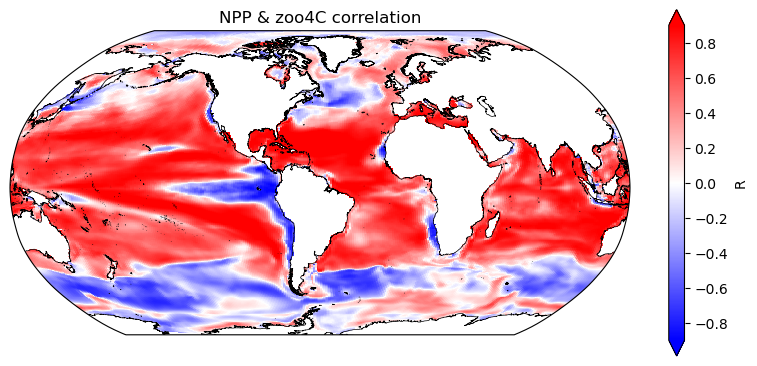

In [75]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4C_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo4C correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### what is the connection between SW heat flux and diatom fraction?

In [76]:
%%time
diatNPPfrac_SW_corr = xr.corr(ds.diatNPPfrac.isel(time=slice(2,61)), ds.SHF_QSW.isel(time=slice(2,61)), dim='time').squeeze()

CPU times: user 181 ms, sys: 189 ms, total: 370 ms
Wall time: 431 ms


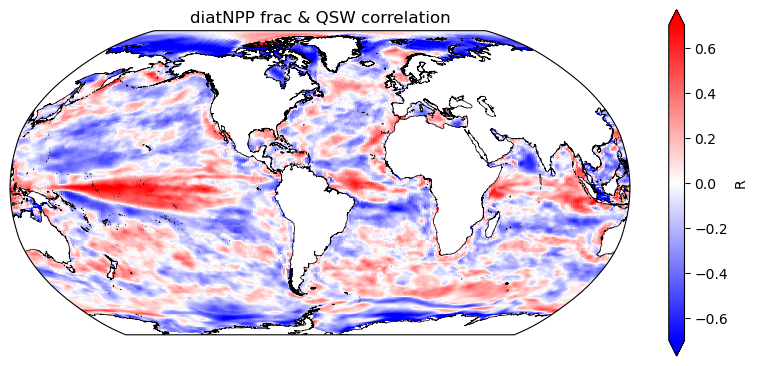

In [77]:
lon, lat, field = adjust_pop_grid(lons, lats, diatNPPfrac_SW_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatNPP frac & QSW correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.7,vmax=0.7,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### sp frac?

In [78]:
%%time
spNPPfrac_SW_corr = xr.corr(ds.spNPPfrac.isel(time=slice(2,61)), ds.SHF_QSW.isel(time=slice(2,61)), dim='time').squeeze()

CPU times: user 179 ms, sys: 194 ms, total: 372 ms
Wall time: 376 ms


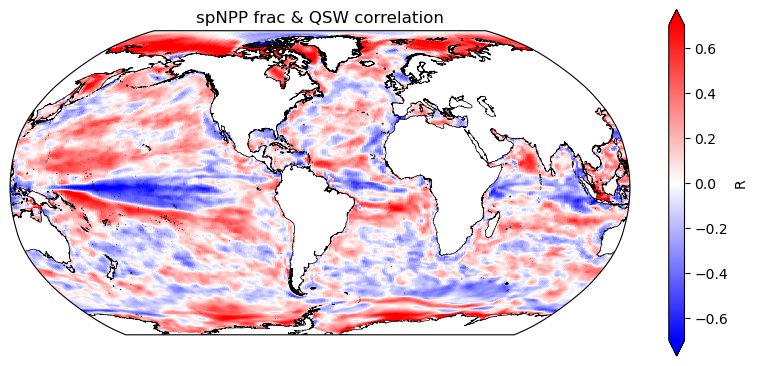

In [79]:
lon, lat, field = adjust_pop_grid(lons, lats, spNPPfrac_SW_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spNPP frac & QSW correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.7,vmax=0.7,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [80]:
%%time
NPP_SW_corr = xr.corr(ds.photoC_TOT_zint.isel(time=slice(2,61)), ds.SHF_QSW.isel(time=slice(2,61)), dim='time').squeeze()

CPU times: user 161 ms, sys: 135 ms, total: 296 ms
Wall time: 302 ms


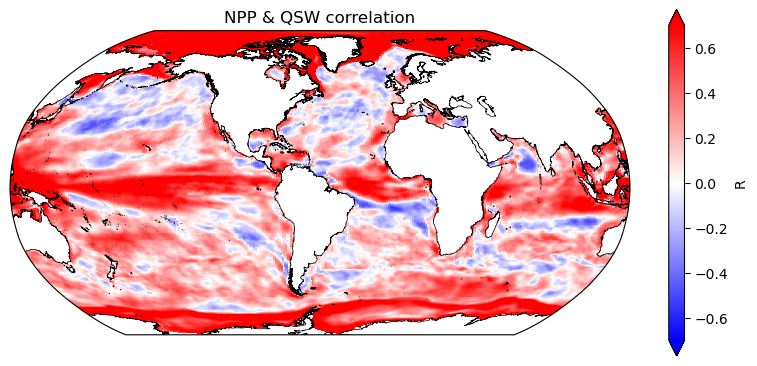

In [81]:
lon, lat, field = adjust_pop_grid(lons, lats, NPP_SW_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & QSW correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.7,vmax=0.7,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

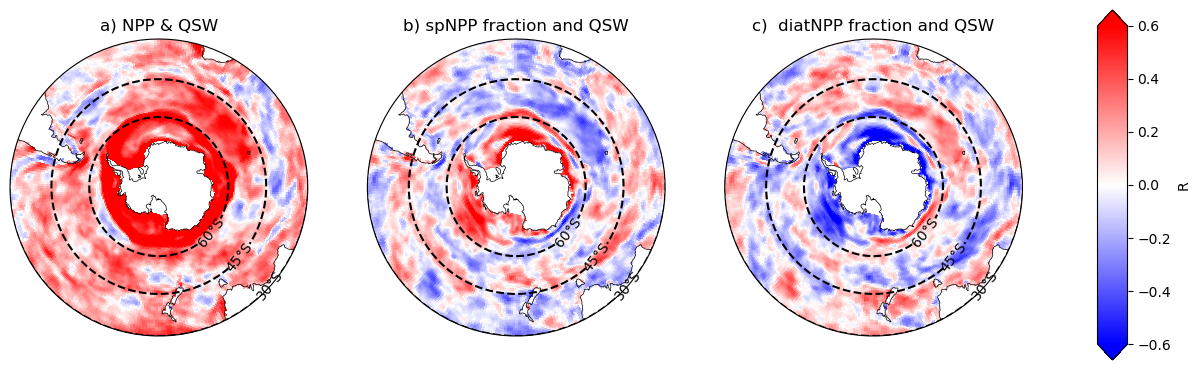

In [82]:
fig = plt.figure(figsize=(15,5))

############################################################ NPP and QSW
lon, lat, field = adjust_pop_grid(lons, lats, NPP_SW_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) NPP & QSW')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = adjust_pop_grid(lons, lats, lats)
pci=ax.contour(lon, lat, 
                 field, 
                 levels=[-60,-45,-30], 
                 colors='black',
                 transform=ccrs.PlateCarree())
fmt = {}
strs = ['60°S','45°S','30°S']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

############################################################ spNPPfraction and QSW
ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) spNPP fraction and QSW')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

lon, lat, field = adjust_pop_grid(lons, lats, spNPPfrac_SW_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]


#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = adjust_pop_grid(lons, lats, lats)
pci=ax.contour(lon, lat, 
                 field, 
                 levels=[-60,-45,-30], 
                 colors='black',
                 transform=ccrs.PlateCarree())
fmt = {}
strs = ['60°S','45°S','30°S']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

############################################################################# diatNPPfraction and QSW


ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c)  diatNPP fraction and QSW')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

lon, lat, field = adjust_pop_grid(lons, lats, diatNPPfrac_SW_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = adjust_pop_grid(lons, lats, lats)
pci=ax.contour(lon, lat, 
                 field, 
                 levels=[-60,-45,-30], 
                 colors='black',
                 transform=ccrs.PlateCarree())
fmt = {}
strs = ['60°S','45°S','30°S']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

#################################################### color bar


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='both', label='R');


#fig.savefig('/glade/u/home/kristenk/TTE_CESM-LE/figs/SO_maps_diatfrac_lims.png',dpi=300)

In [83]:
%%time
splightlim_diatNPPfrac_corr = xr.corr(ds.diatNPPfrac.isel(time=slice(2,61)), ds.sp_light_lim_Cweight_avg_100m.isel(time=slice(2,61)), dim='time').squeeze()

CPU times: user 178 ms, sys: 177 ms, total: 355 ms
Wall time: 474 ms


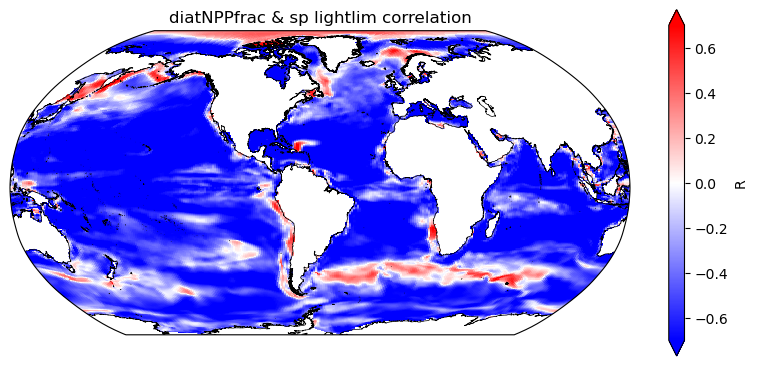

In [84]:
lon, lat, field = adjust_pop_grid(lons, lats, splightlim_diatNPPfrac_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatNPPfrac & sp lightlim correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.7,vmax=0.7,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [33]:
%%time
zratio_NPP_ann_corr = xr.corr(ds.zratio.isel(time=slice(2,61)), ds.photoC_TOT_zint.isel(time=slice(2,61)), dim='time')
zratio_NPP_ann_corr = zratio_NPP_ann_corr.squeeze()

CPU times: user 141 ms, sys: 77 ms, total: 218 ms
Wall time: 444 ms


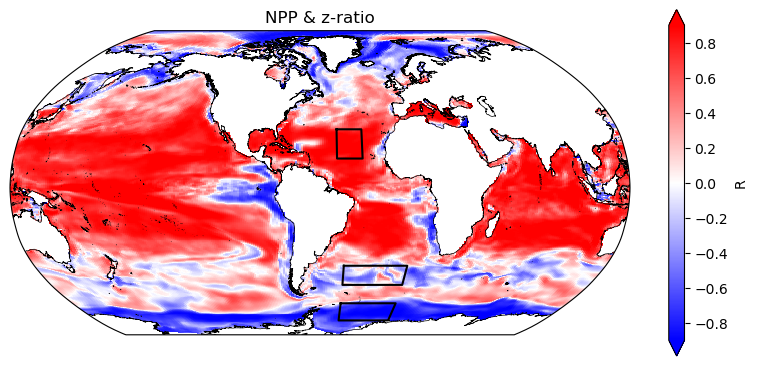

In [34]:
lon, lat, field = adjust_pop_grid(lons, lats, zratio_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & z-ratio', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_zratio_R_withboxes.png',dpi=300)

In [65]:
%%time
z2ratio_NPP_ann_corr = xr.corr(ds.z2ratio.isel(time=slice(2,61)), ds.photoC_TOT_zint.isel(time=slice(2,61)), dim='time')
z2ratio_NPP_ann_corr = z2ratio_NPP_ann_corr.squeeze()

CPU times: user 192 ms, sys: 166 ms, total: 358 ms
Wall time: 544 ms


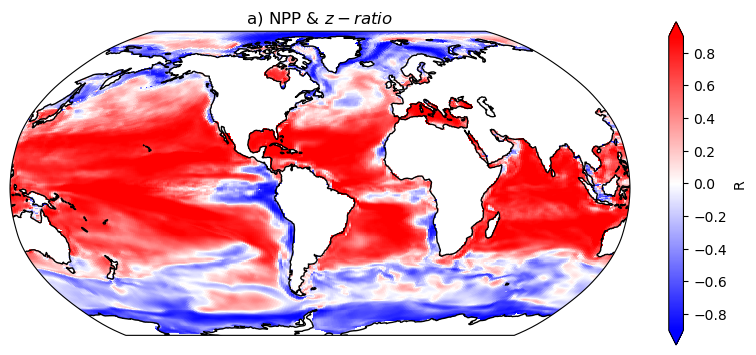

In [66]:
lon, lat, field = adjust_pop_grid(lons, lats, z2ratio_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.2))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) NPP & ${\it z-ratio}$', fontsize=12)
ax.coastlines('110m',linewidth=1)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_z2ratio_R.png',dpi=300)

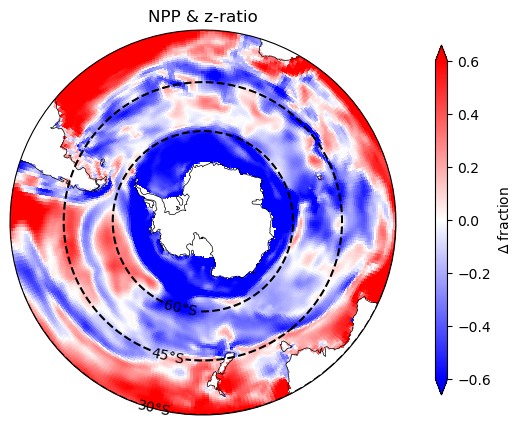

In [67]:
fig = plt.figure(figsize=(6,5))

############################################################ NPP and QSW
lon, lat, field = adjust_pop_grid(lons, lats, z2ratio_NPP_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP & z-ratio')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


######### lat lines
lon, lat, field = adjust_pop_grid(lons, lats, lats)
pci=ax.contour(lon, lat, 
                 field, 
                 levels=[-60,-45,-30], 
                 colors='black',
                 transform=ccrs.PlateCarree())
fmt = {}
strs = ['60°S','45°S','30°S']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)


#################################################### color bar


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='both', label='${\Delta}$ fraction');


#fig.savefig('/glade/u/home/kristenk/TTE_CESM-LE/figs/SO_maps_diatfrac_lims.png',dpi=300)

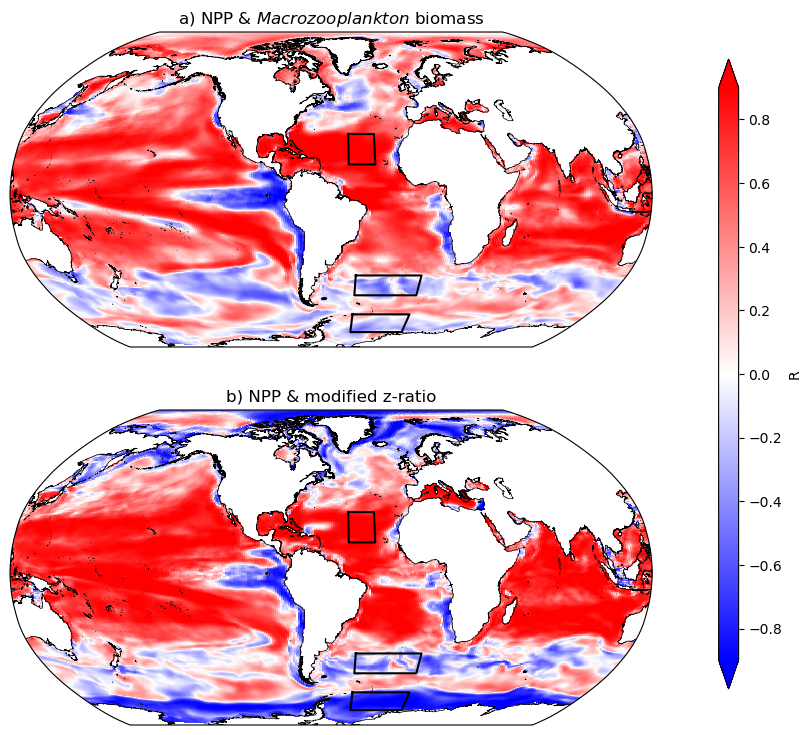

In [105]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4C_NPP_ann_corr2)

fig = plt.figure(figsize=(10,9))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) NPP & ${\it Macrozooplankton}$ biomass', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

####################


lon, lat, field = adjust_pop_grid(lons, lats, z2ratio_NPP_ann_corr)

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) NPP & modified z-ratio', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
# box1
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box2
lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# box3
lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())






fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='both', label='R');
#fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_z2ratio_R_withboxes.png',dpi=300)

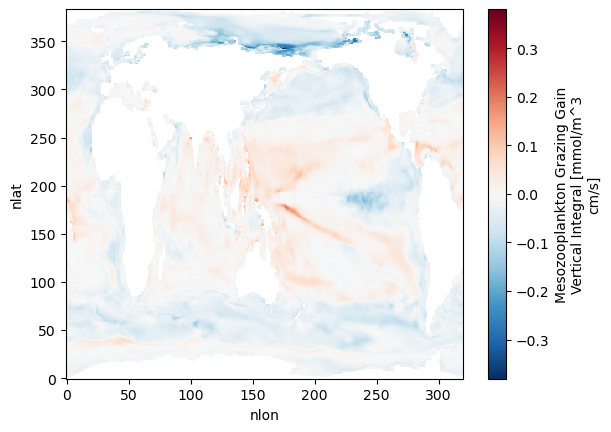

In [37]:
diff = z2ratio_NPP_ann_corr - zratio_NPP_ann_corr
diff.plot()

In [45]:
HTLfood_NPP_ann_corr = xr.corr(ds.HTLfood_zint.isel(time=slice(2,61)), ds.photoC_TOT_zint.isel(time=slice(2,61)), dim='time')
HTLfood_NPP_ann_corr = HTLfood_NPP_ann_corr.squeeze()

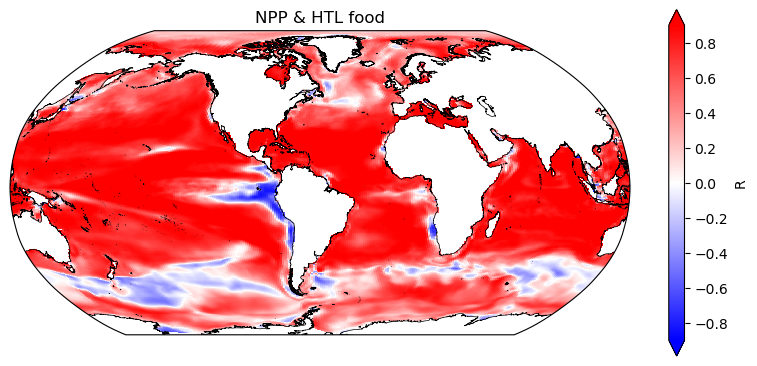

In [47]:
lon, lat, field = adjust_pop_grid(lons, lats, HTLfood_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & HTL food', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_HTLfood_R.png',dpi=300)

In [48]:
%%time
zoo4ratio_NPP_ann_corr = xr.corr(ds.zoo4ratio.isel(time=slice(2,61)), ds.photoC_TOT_zint.isel(time=slice(2,61)), dim='time')
zoo4ratio_NPP_ann_corr = zoo4ratio_NPP_ann_corr.squeeze()

CPU times: user 184 ms, sys: 172 ms, total: 356 ms
Wall time: 420 ms


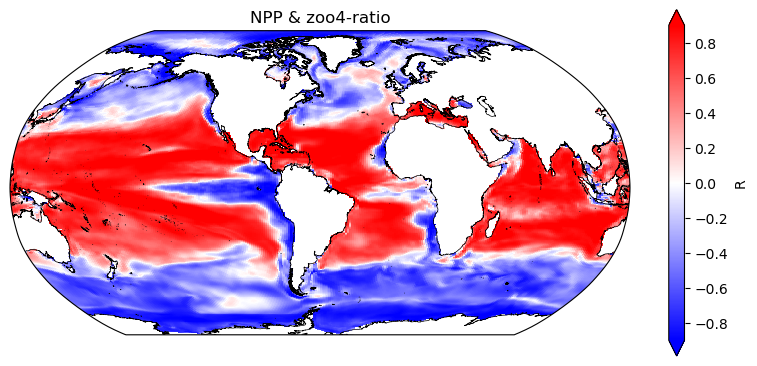

In [49]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4ratio_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo4-ratio', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_zoo4ratio_R.png',dpi=300)

In [42]:
%%time
zoo3C_NPP_ann_corr = xr.corr(ds.zoo3C_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zoo3C_NPP_ann_corr = zoo3C_NPP_ann_corr.squeeze()

CPU times: user 809 ms, sys: 748 ms, total: 1.56 s
Wall time: 1.68 s


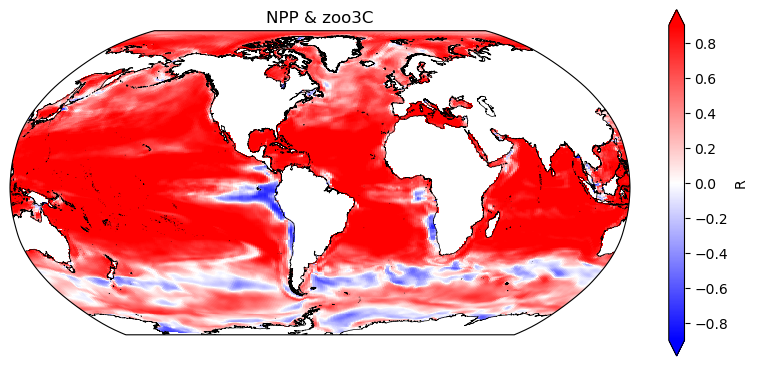

In [43]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo3C_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo3C', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### Correlations between NPP and other biomass/production

In [44]:
%%time
zoo2C_NPP_ann_corr = xr.corr(ds.zoo2C_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zoo2C_NPP_ann_corr = zoo2C_NPP_ann_corr.squeeze()

CPU times: user 855 ms, sys: 825 ms, total: 1.68 s
Wall time: 1.82 s


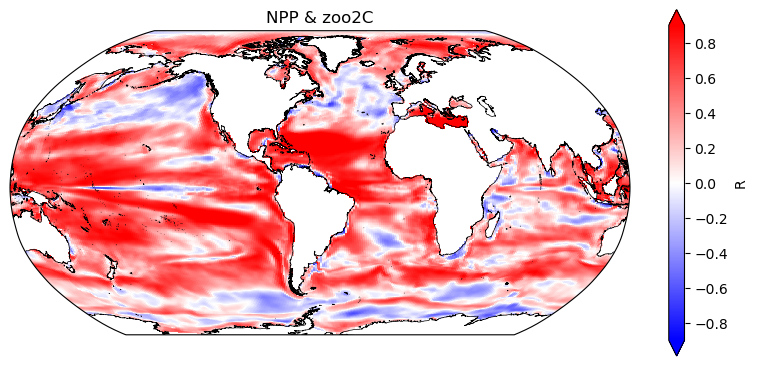

In [45]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo2C_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo2C', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [46]:
%%time
zoo1C_NPP_ann_corr = xr.corr(ds.zoo1C_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
zoo1C_NPP_ann_corr = zoo1C_NPP_ann_corr.squeeze()

CPU times: user 834 ms, sys: 815 ms, total: 1.65 s
Wall time: 1.8 s


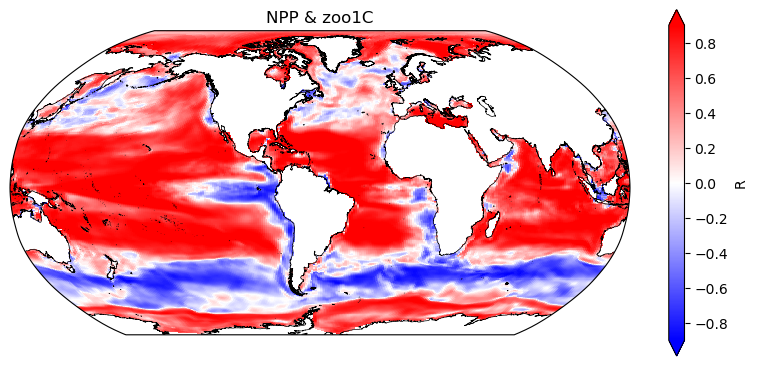

In [47]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo1C_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & zoo1C', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [48]:
%%time
microzooC_NPP_ann_corr = xr.corr((ds.zoo1C_zint.isel(time=slice(22,61)) + ds.zoo2C_zint.isel(time=slice(22,61))), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
microzooC_NPP_ann_corr = microzooC_NPP_ann_corr.squeeze()

CPU times: user 1.53 s, sys: 1.55 s, total: 3.08 s
Wall time: 4.22 s


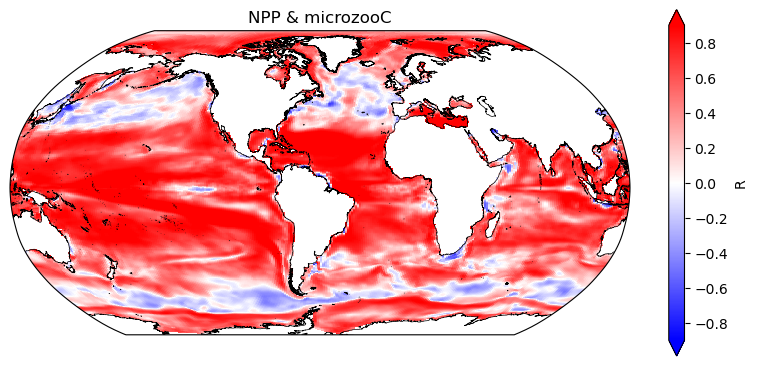

In [49]:
lon, lat, field = adjust_pop_grid(lons, lats, microzooC_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & microzooC', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [50]:
%%time
diatC_NPP_ann_corr = xr.corr(ds.diatC_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
diatC_NPP_ann_corr = diatC_NPP_ann_corr.squeeze()

CPU times: user 866 ms, sys: 811 ms, total: 1.68 s
Wall time: 1.79 s


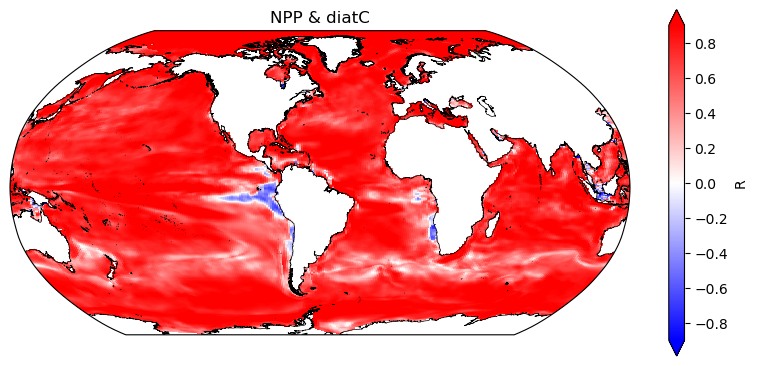

In [51]:
lon, lat, field = adjust_pop_grid(lons, lats, diatC_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & diatC', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [52]:
%%time
diatNPP_NPP_ann_corr = xr.corr(ds.photoC_diat_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
diatNPP_NPP_ann_corr = diatNPP_NPP_ann_corr.squeeze()

CPU times: user 123 ms, sys: 40.2 ms, total: 164 ms
Wall time: 275 ms


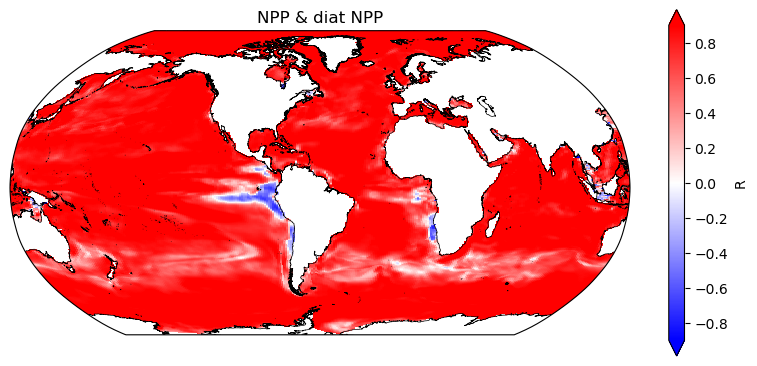

In [53]:
lon, lat, field = adjust_pop_grid(lons, lats, diatNPP_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & diat NPP', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [54]:
%%time
spC_NPP_ann_corr = xr.corr(ds.spC_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
spC_NPP_ann_corr = spC_NPP_ann_corr.squeeze()

CPU times: user 829 ms, sys: 762 ms, total: 1.59 s
Wall time: 1.7 s


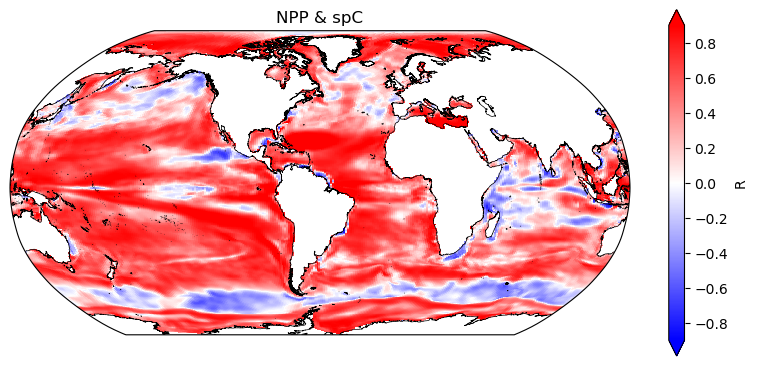

In [55]:
lon, lat, field = adjust_pop_grid(lons, lats, spC_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & spC', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [56]:
%%time
spNPP_NPP_ann_corr = xr.corr(ds.photoC_sp_zint.isel(time=slice(22,61)), ds.photoC_TOT_zint.isel(time=slice(22,61)), dim='time')
spNPP_NPP_ann_corr = spNPP_NPP_ann_corr.squeeze()

CPU times: user 131 ms, sys: 46.6 ms, total: 177 ms
Wall time: 314 ms


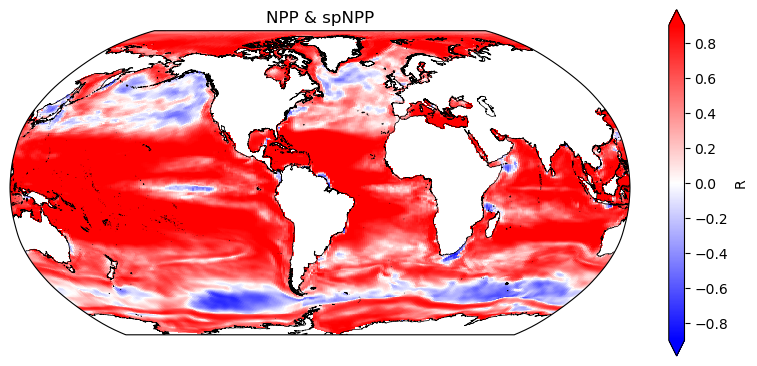

In [57]:
lon, lat, field = adjust_pop_grid(lons, lats, spNPP_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & spNPP', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [96]:
%%time
diatNPPfrac_zoo4C_ann_corr = xr.corr(ds.diatNPPfrac.isel(time=slice(2,61)), ds.zoo4C_zint.isel(time=slice(2,61)), dim='time')
diatNPPfrac_zoo4C_ann_corr = diatNPPfrac_zoo4C_ann_corr.squeeze()

CPU times: user 869 ms, sys: 811 ms, total: 1.68 s
Wall time: 1.87 s


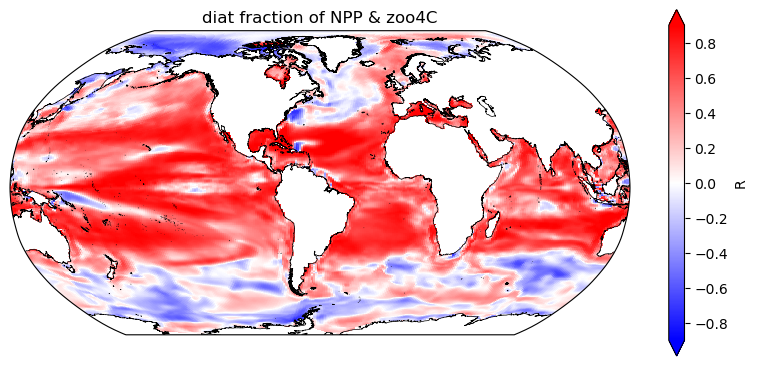

In [97]:
lon, lat, field = adjust_pop_grid(lons, lats, diatNPPfrac_zoo4C_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diat fraction of NPP & zoo4C', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [58]:
%%time
diatNPPfrac_NPP_ann_corr = xr.corr(ds.diatNPPfrac.isel(time=slice(2,61)), ds.photoC_TOT_zint.isel(time=slice(2,61)), dim='time')
diatNPPfrac_NPP_ann_corr = diatNPPfrac_NPP_ann_corr.squeeze()

CPU times: user 193 ms, sys: 70.7 ms, total: 264 ms
Wall time: 402 ms


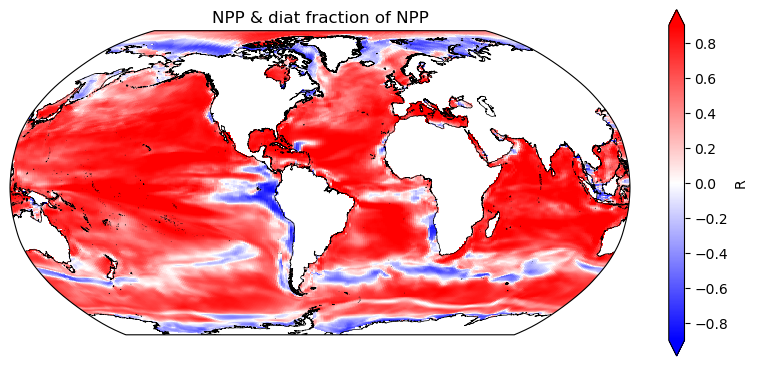

In [59]:
lon, lat, field = adjust_pop_grid(lons, lats, diatNPPfrac_NPP_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('NPP & diat fraction of NPP', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [60]:
%%time
diatNPPfrac_zoo4prod_ann_corr = xr.corr(ds.diatNPPfrac.isel(time=slice(2,61)), ds.x_graze_zoo4_zint.isel(time=slice(2,61)), dim='time').squeeze()

CPU times: user 202 ms, sys: 107 ms, total: 310 ms
Wall time: 1.09 s


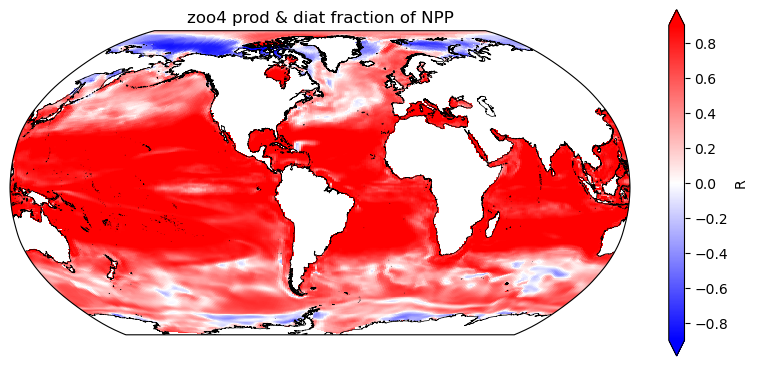

In [61]:
lon, lat, field = adjust_pop_grid(lons, lats, diatNPPfrac_zoo4prod_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4 prod & diat fraction of NPP', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

In [62]:
%%time
diatNPPfrac_zoo3prod_ann_corr = xr.corr(ds.diatNPPfrac.isel(time=slice(2,61)), ds.x_graze_zoo3_zint.isel(time=slice(2,61)), dim='time').squeeze()

CPU times: user 188 ms, sys: 112 ms, total: 300 ms
Wall time: 444 ms


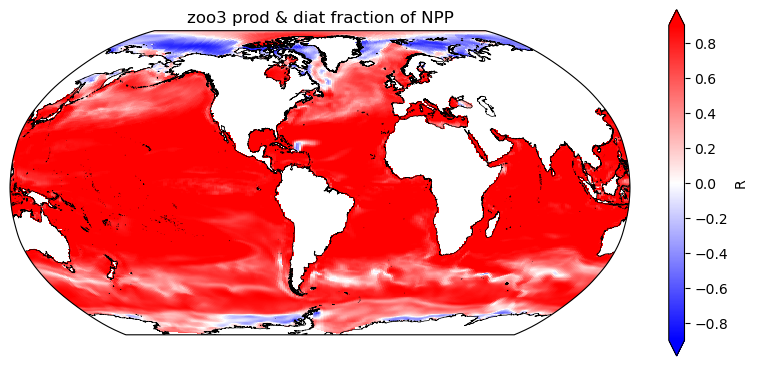

In [63]:
lon, lat, field = adjust_pop_grid(lons, lats, diatNPPfrac_zoo3prod_ann_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo3 prod & diat fraction of NPP', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.9,vmax=0.9,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')